<h1> Ensemble generation submission and analysis notebook </h1>

This script uses a combination of bash and python cells to form a workflow for creating and analysing FATES (or any CLM) ensembles. It will:

<ol>
<li>Clone the github repo 
<li>Make and build a default 4x5 CLM-FATES case
<li>Make an ensemble of CLM-FATES cases 
<li>Generate an ensemble of parameter files with one at a time or latin hypercube  modification
<li>Point each ensemble member at a different parameter file
<li>Submit all these jobs
<li>Analyse output
</ol>

<h4>n.b. This notebook is also set up to work with Cheyenne specific paths, but can be modified. 
<h4>n.b. The version here is relatively simple in that it just submits a one at a time sensemble and plots maps of the output. Obviously much more can be made of the ensemble design and analysis but this is here as a generic tool... 

#### Control variables for the analysis script.

In [86]:
# This mega script does 
# ensemble setup (including parameter file generation.  
# job submission and 
# analysis. 

# You can turn these off and on according to where you are tin the process. 

dosetup = 1 #do we want to create parameters files and so on?
dosubmit = 1 #do we do the submission stage, or just the analysis?
forcenewcase = 0 #do we scurb all the old cases and start again?
doanalysis = 1 #do we want to plot the outputs? 
print("setup, submit, analysis:", dosetup,dosubmit,doanalysis)

setup, submit, analysis: 1 1 1


#### Define parameter space for senstivity analysis. 

In [49]:
#aspiration to make this into a dictionary...
parameter_list=['fates_rad_leaf_clumping_index','fates_rad_leaf_xl',
                'fates_rad_leaf_rhovis','fates_rad_stem_rhovis',
                'fates_rad_leaf_tauvis','fates_rad_stem_tauvis' ]

min_delta=[0.5,   0.01,0.75, 0.75, 0.75,0.75]
max_delta=[1/0.85,1.4 ,1.25, 1.25, 1.25,1.25]
print(parameter_list)  

['fates_rad_leaf_clumping_index', 'fates_rad_leaf_xl', 'fates_rad_leaf_rhovis', 'fates_rad_stem_rhovis', 'fates_rad_leaf_tauvis', 'fates_rad_stem_tauvis']


<h3>Set global variables and paths for ensemble analysis </h3>

In [3]:
# FATES mode settings for the ensemble
sp=1 #are we using SP mode?
calib=1 # this script can be run in one at a time and latin hypercube mode.
calibvars=2 #which set of variables are we peturbing?
n=1 #the number of the ensemble. For when you need to do it all again ;) 
dim3=0

### Set pathnames for parameter directories and casenames.

#### Import libraries

In [4]:
import os
import netCDF4 as nc4
import sys
import shutil
import numpy as np
import warnings
warnings.filterwarnings('ignore')
import xarray as xr
from matplotlib import pyplot as plt
#import datetime

In [110]:
# what is your clone of the ctsm repo called? (or you want it to be called?) 
ctsmrepo='ctsmsep22'

#what do you want the directory with the ensemble cases in to be called?
ens_directory='RTM_ens'+str(n)

#what do you want the case names to begin with?
caseroot=ens_directory+'_case_'

USER='rfisher'

#path to scratch (or where the model is built.)
defbuildroot='/glade/scratch/'

#path to scratch (or where the model is built.)
output_dir='/glade/scratch/'+USER+'/'

#how many members are in the ensemble?
ncases=12 

#where are we now?
notebookdr=os.getcwd()  



#### SP/NOCOMP specific paths to default case/param files

In [6]:
if(sp == 1): #Settings for the SP ensemble.
    resub=0 #how many times to resubmit the model. 

    #what is the name of your 'basecase'?
    defcase='fates_crops_smo_minlai_opt_vcmax50'
    
    #what is the base parameter file called?
    paramfiledefault='fates_params_default.nc'    

else: #Settings for the NOCOMP ensemble. 
    resub=2 #how many times do we want to resubmit the job?
    
    #what is the name of your 'basecase'?
    defcase='SPdefault_sept'
    
    #what is the base parameter file called?
    paramfiledefault='param_files_nocomp_'+str(n)   
    paramfiledefault='/glade/u/home/rfisher/fates_sp_ensembles/param_files_sp_n6_noc4/calib_paramfiledefault.nc'
    
print(caseroot)


RTM_ens1_case_


#### Clone CTSM repo (if necessary).

##### (This box and others like it go into BASH script 'mode', and hence isn't in python) 

In [7]:
%%bash -s "$ctsmrepo" "$dosetup"
ctsmrepo=$1
dosetup=$2

if [ $dosetup -eq 1 ]
then
cd /glade/work/$USER/
#go to git directory
if [[ -d "git" ]]
then
cd git
else
mkdir git
cd git
fi

#go to git repo, or checkout code
if [[ -d "$ctsmrepo" ]]
then
cd $ctsmrepo
echo "Already have ctsm repo"
else
echo "Cloning ctsm"
#clone CTSM code if you didn't to this already. 
#git clone https://github.com/escomp/ctsm $ctsmrepo
cd $ctsmrepo
#./manage_externals/checkout_externals
cd src
fi
fi
echo "Currently in" $(pwd)

Already have ctsm repo
Currently in /glade/work/rfisher/git/ctsmsep22


<h4> Make a default FATES 4x5 case (this will take a while if it has to build) </h4>

In [8]:
%%bash -s "$ctsmrepo" "$dosetup" "$defcase" 
ctsmrepo=$1
dosetup=$2
defcase=$3
echo "defcase is" $defcase
echo "setup=" $dosetup
echo $dosetup
compset=2000_DATM%GSWP3v1_CLM50%FATES_SICE_SOCN_MOSART_SGLC_SWAV_SESP
if [[ $dosetup -eq 1 ]]
then
cd /glade/work/$USER/git/$ctsmrepo/cime/scripts
if [[ -d "$defcase" ]]
then
    echo "$defcase exists on your filesystem." .$defcase
else
    echo "making defcase.",$defcase
./create_newcase --case $defcase --compset 2000_DATM%GSWP3v1_CLM50%FATES_SICE_SOCN_MOSART_SGLC_SWAV_SESP --res f45_f45_mg37  --run-unsupported
cd $defcase
./case.setup
./case.build
fi
fi
echo "Currently in" $(pwd)

defcase is fates_crops_smo_minlai_opt_vcmax50
setup= 1
1
fates_crops_smo_minlai_opt_vcmax50 exists on your filesystem. .fates_crops_smo_minlai_opt_vcmax50
Currently in /glade/work/rfisher/git/ctsmsep22/cime/scripts


#### Adjust settings of default case. 

In [9]:
%%bash -s "$ctsmrepo" "$defcase" "$dosetup" "$defbuildroot" 

ctsmrepo=$1
defcase=$2
dosetup=$3
defbuildroot=$4

if [[ $dosetup -eq 1 ]]
then
defbld=$defbuildroot$USER/$defcase/bld
cd /glade/work/$USER/git/$ctsmrepo/cime/scripts/$defcase

echo 'updating settings'
./xmlchange CONTINUE_RUN=FALSE;  
./xmlchange --id STOP_N --val 5;  #number of years of simulation
./xmlchange --id STOP_OPTION --val nyears;
./xmlchange --id CLM_FORCE_COLDSTART --val on;
echo "Currently in" $(pwd)
fi

updating settings
Currently in /glade/work/rfisher/git/ctsmsep22/cime/scripts/fates_crops_smo_minlai_opt_vcmax50


#### Make a default user_nl_clm file

In [10]:
%%bash -s "$ctsmrepo" "$defcase" "$dosetup" "$ens_directory" "$sp"

ctsmrepo=$1
defcase=$2
dosetup=$3
ens_directory=$4
usesp=$5

if [[ $dosetup -eq 1 ]]
then
cd /glade/work/$USER/git/$ctsmrepo/cime/scripts
cd $defcase

if [ -f "user_nl_clm_store" ] #did we do this already?
then
#move the stored version to the default version
cp user_nl_clm_store  user_nl_clm_default
else
#store the 'vanilla' user_nl_clm file
cp user_nl_clm  user_nl_clm_store
# and then make a copy of that to act as the default for the ensemble. 
cp user_nl_clm_store  user_nl_clm_default
fi 

if [[ $usesp -eq 1 ]] #change to SP mode. 
then
echo use_fates_sp=.true. >> user_nl_clm_default
fi
echo fates_paramfile = "nullparameterfile" >> user_nl_clm_default
 
echo "Currently in" $(pwd)
cp user_nl_clm_default ../$ens_directory/user_nl_clm_default
fi

cat user_nl_clm_default
#n.b. i overwrote this with a file in the ensemble directory last time i did it.

Currently in /glade/work/rfisher/git/ctsmsep22/cime/scripts/fates_crops_smo_minlai_opt_vcmax50
!----------------------------------------------------------------------------------
! Users should add all user specific namelist changes below in the form of 
! namelist_var = new_namelist_value 
!
! EXCEPTIONS: 
! Set use_cndv           by the compset you use and the CLM_BLDNML_OPTS -dynamic_vegetation setting
! Set use_vichydro       by the compset you use and the CLM_BLDNML_OPTS -vichydro           setting
! Set use_cn             by the compset you use and CLM_BLDNML_OPTS -bgc  setting
! Set use_crop           by the compset you use and CLM_BLDNML_OPTS -crop setting
! Set spinup_state       by the CLM_BLDNML_OPTS -bgc_spinup      setting
! Set co2_ppmv           with CCSM_CO2_PPMV                      option
! Set fatmlndfrc         with LND_DOMAIN_PATH/LND_DOMAIN_FILE    options
! Set finidat            with RUN_REFCASE/RUN_REFDATE/RUN_REFTOD options for hybrid or branch cases
!        

<h3> Make ensemble of cases.</h3>

In [11]:
%%capture
%%bash -s "$ctsmrepo" "$defcase" c "$ens_directory" "$caseroot" "$ncases" "$forcenewcase"

ctsmrepo=$1
defcase=$2
dosetup=$3
ens_directory=$4
caseroot=$5
ncases=$6
forcenewcase=$7

echo "ncases=" $ncases
echo "caseroot=" $caseroot
echo "dosetup=" $dosetup
echo "forcenewcase=" $forcenewcase
echo "ens_directory=" $ens_directory

if [[ $dosetup -eq 1 ]]
then
echo "setup"

cd /glade/work/$USER/git/$ctsmrepo/cime/scripts

if [[ -d "$ens_directory" ]]
then
echo "already have ensemble directory"
else
mkdir $ens_directory
fi 

#make directory for parameter files. 
cd $ens_directory
if [[ -d "parameter_files" ]]
then
echo "already have parameter_files directory"
else
mkdir parameter_files
fi 
cd ..

counter1=0 #include a default zero case. 
while [ $counter1 -le $ncases ]
do
  newcase=$caseroot$counter1 #name of ensemble membr case.    
  if [ -d $ens_directory/$newcase ]
  then
    echo ' new case already exists',$ens_directory/$newcase
    if [ $forcenewcase -eq 1 ]
    then
    echo 'force making case', $ens_directory/$newcase
    rm -rf $ens_directory/$newcase
    ./create_clone --clone $defcase --case $ens_directory/$newcase ;
    fi    
  else
   echo 'making new case', $ens_directory/$newcase
    ./create_clone --clone $defcase --case $ens_directory/$newcase ;
  fi
((counter1++))
done

counter1=0 #include a default zero case. 
while [ $counter1 -le $ncases ]
do
  newcase=$caseroot$counter1 #name of ensemble membr case.   
   cd $ens_directory/$newcase
   echo 'case setup', $ens_directory/$newcase
   ./case.setup;
    cd ../../ 
((counter1++))
done
fi

<h3> Create .nc version of current defualt file. I FAILED ATT THIS. NEEDS INPUT..</h3>
You currently have to do this step manually, by doing this in the terminal:

<i> cd /glade/work/$USER/git/$ctsmrepo/src/fates/parameter_files/</i><br>
<i>ncgen -o fates_params_default.nc fates_params_default.cdl </i>

#### Copy default .nc template parameter file to ensemble parameter directory . 

In [60]:
if(dosetup == 1): 
    paramsdir='/glade/work/'+USER+'/git/'+ctsmrepo+'/cime/scripts/'+ens_directory+'/parameter_files'
    defparamfile='/glade/work/'+USER+'/git/'+ctsmrepo+'/src/fates/parameter_files/'+paramfiledefault
    filename_template = paramsdir+'/'+paramfiledefault
    try:
        os.remove(filename_template)
    except:
        print('file does not yet exist: '+filename_template)
    shutil.copy(defparamfile,filename_template)
    print('default parameters in'+filename_template)

file does not yet exist: /glade/work/rfisher/git/ctsmsep22/cime/scripts/RTM_ens1/parameter_files/fates_params_default.nc
default parameters in/glade/work/rfisher/git/ctsmsep22/cime/scripts/RTM_ens1/parameter_files/fates_params_default.nc


#### Create ensemble of parameter files

In [61]:
if(dosetup == 1): 
    fatesparamfile= 'fates_params_'+ens_directory+'_'
    vs=range(0,ncases+1) 
    for i in vs:
        filename_out = paramsdir+'/'+fatesparamfile+str(i)+'.nc' 
        print('make:'+filename_out)
        try:
            os.remove(filename_out)
        except:
            print('file does not yet exist: '+filename_out)
        shutil.copy(filename_template,filename_out)

make:/glade/work/rfisher/git/ctsmsep22/cime/scripts/RTM_ens1/parameter_files/fates_params_RTM_ens1_0.nc
make:/glade/work/rfisher/git/ctsmsep22/cime/scripts/RTM_ens1/parameter_files/fates_params_RTM_ens1_1.nc
make:/glade/work/rfisher/git/ctsmsep22/cime/scripts/RTM_ens1/parameter_files/fates_params_RTM_ens1_2.nc
make:/glade/work/rfisher/git/ctsmsep22/cime/scripts/RTM_ens1/parameter_files/fates_params_RTM_ens1_3.nc
make:/glade/work/rfisher/git/ctsmsep22/cime/scripts/RTM_ens1/parameter_files/fates_params_RTM_ens1_4.nc
make:/glade/work/rfisher/git/ctsmsep22/cime/scripts/RTM_ens1/parameter_files/fates_params_RTM_ens1_5.nc
make:/glade/work/rfisher/git/ctsmsep22/cime/scripts/RTM_ens1/parameter_files/fates_params_RTM_ens1_6.nc
make:/glade/work/rfisher/git/ctsmsep22/cime/scripts/RTM_ens1/parameter_files/fates_params_RTM_ens1_7.nc
make:/glade/work/rfisher/git/ctsmsep22/cime/scripts/RTM_ens1/parameter_files/fates_params_RTM_ens1_8.nc
make:/glade/work/rfisher/git/ctsmsep22/cime/scripts/RTM_ens1/par

#### Make function to modify FATES parameter files. 

In [62]:
def def_pftfile( fileroot,i,variable,delta):   
    pfilename = fileroot+str(i)+'.nc' 
    fin = nc4.Dataset(pfilename, 'r+')
    print('modifying parameter file',i,variable,delta);
    var = fin.variables[variable]
    var[:] = var[:]*delta
    fin.close()

#### Modify parameter files (one at a time)

In [63]:
#n.b. I (RAF) have other scripts that do LHC sampling or n dimensional arrays. 
#just including this one at a time example here for simplicity. 

if(dosetup == 1): 
    fileroot =  paramsdir+'/'+fatesparamfile 
    if(sp == 1):
        for p in range(0,6):
            def_pftfile(fileroot,p*2+1,parameter_list[p],min_delta[p])
            def_pftfile(fileroot,p*2+2,parameter_list[p],max_delta[p])


modifying parameter file 1 fates_rad_leaf_clumping_index 0.5
modifying parameter file 2 fates_rad_leaf_clumping_index 1.1764705882352942
modifying parameter file 3 fates_rad_leaf_xl 0.01
modifying parameter file 4 fates_rad_leaf_xl 1.4
modifying parameter file 5 fates_rad_leaf_rhovis 0.75
modifying parameter file 6 fates_rad_leaf_rhovis 1.25
modifying parameter file 7 fates_rad_stem_rhovis 0.75
modifying parameter file 8 fates_rad_stem_rhovis 1.25
modifying parameter file 9 fates_rad_leaf_tauvis 0.75
modifying parameter file 10 fates_rad_leaf_tauvis 1.25
modifying parameter file 11 fates_rad_stem_tauvis 0.75
modifying parameter file 12 fates_rad_stem_tauvis 1.25


#### Point each ensemble script at different parameter file

In [26]:
if(dosetup == 1): 
    root= '/glade/work/'+USER+'/git/'+ctsmrepo+'/cime/scripts/'+ens_directory+'/'
    fatesparamfile=root+'fates_params_'+ens_directory+'_'
    vs=range(0,ncases+1) 
    for i in vs:
        pftfilename = paramsdir+'/'+fatesparamfile+str(i)+'.nc'    
        unlfile=root+caseroot+str(i)+'/'+'user_nl_clm'
        print('unl='+unlfile)   
        fin = open(unlfile, "rt")     
        data = fin.read()   #read file contents to string   
        data = data.replace('pyton', 'python') #replace all occurrences of the required string        
        fin.close() #close the input file       
        fin = open(unlfile, "wt") #open the input file in write mode     
        fin.write(data) #overrite the input file with the resulting data       
        fin.close() #close the file

unl=/glade/work/rfisher/git/ctsmsep22/cime/scripts/RTM_ens1/RTM_ens1_case_0/user_nl_clm
unl=/glade/work/rfisher/git/ctsmsep22/cime/scripts/RTM_ens1/RTM_ens1_case_1/user_nl_clm
unl=/glade/work/rfisher/git/ctsmsep22/cime/scripts/RTM_ens1/RTM_ens1_case_2/user_nl_clm
unl=/glade/work/rfisher/git/ctsmsep22/cime/scripts/RTM_ens1/RTM_ens1_case_3/user_nl_clm
unl=/glade/work/rfisher/git/ctsmsep22/cime/scripts/RTM_ens1/RTM_ens1_case_4/user_nl_clm
unl=/glade/work/rfisher/git/ctsmsep22/cime/scripts/RTM_ens1/RTM_ens1_case_5/user_nl_clm
unl=/glade/work/rfisher/git/ctsmsep22/cime/scripts/RTM_ens1/RTM_ens1_case_6/user_nl_clm
unl=/glade/work/rfisher/git/ctsmsep22/cime/scripts/RTM_ens1/RTM_ens1_case_7/user_nl_clm
unl=/glade/work/rfisher/git/ctsmsep22/cime/scripts/RTM_ens1/RTM_ens1_case_8/user_nl_clm
unl=/glade/work/rfisher/git/ctsmsep22/cime/scripts/RTM_ens1/RTM_ens1_case_9/user_nl_clm
unl=/glade/work/rfisher/git/ctsmsep22/cime/scripts/RTM_ens1/RTM_ens1_case_10/user_nl_clm
unl=/glade/work/rfisher/git/cts

#### Check parameter files were correctly modifed

In [77]:
i=5
paramnum=2
pf= paramsdir+'/'+fatesparamfile+str(0)+'.nc' 
find = nc4.Dataset(pf, 'r+')
vardef=find.variables[parameter_list[paramnum]]
pf= paramsdir+'/'+fatesparamfile+str(i)+'.nc' 
finm = nc4.Dataset(pf, 'r+')
varmod=finm.variables[parameter_list[paramnum]]
print('actual ratio:',np.divide(varmod[:],vardef[:]))
print('target ratio:',min_delta[paramnum])

actual ratio: [0.75 0.75 0.75 0.75 0.75 0.75 0.75 0.75 0.75 0.75 0.75 0.75]
target ratio: 0.75


<h3>Submit ensemble of cases</h3>

In [78]:
%%capture
%%bash -s "$ctsmrepo" "$defcase" "$ens_directory" "$caseroot" "$ncases" "$dosubmit" 

ctsmrepo=$1
defcase=$2
ens_directory=$3
caseroot=$4
ncases=$5
dosubmit=$6

if [ $dosubmit -eq 1 ]
then
cd /glade/work/$USER/git/$ctsmrepo/cime/scripts
echo 'submitting'
startcase=0
counter1=$startcase
cd $ens_directory
pwd

while [ $counter1 -le $ncases ]
do
  echo $counter1
  newcase=$caseroot$counter1
  echo $newcase

  if [ -d $newcase ]
  then
    cd $newcase
    cat user_nl_clm
    echo 'submitting job',$newcase
    ./xmlchange BUILD_COMPLETE=TRUE
    #./xmlchange RESUBMIT=1
   # ./xmlchange PROJECT=P93300041
    ./case.submit
    cd ../
  else
   echo 'no case', $newcase
  fi

  ((counter1++))
  done
else
echo "not submitting jobs"
fi

submitting
/glade/work/rfisher/git/ctsmsep22/cime/scripts/RTM_ens1
0
RTM_ens1_case_0
!----------------------------------------------------------------------------------
! Users should add all user specific namelist changes below in the form of 
! namelist_var = new_namelist_value 
!
! EXCEPTIONS: 
! Set use_cndv           by the compset you use and the CLM_BLDNML_OPTS -dynamic_vegetation setting
! Set use_vichydro       by the compset you use and the CLM_BLDNML_OPTS -vichydro           setting
! Set use_cn             by the compset you use and CLM_BLDNML_OPTS -bgc  setting
! Set use_crop           by the compset you use and CLM_BLDNML_OPTS -crop setting
! Set spinup_state       by the CLM_BLDNML_OPTS -bgc_spinup      setting
! Set co2_ppmv           with CCSM_CO2_PPMV                      option
! Set fatmlndfrc         with LND_DOMAIN_PATH/LND_DOMAIN_FILE    options
! Set finidat            with RUN_REFCASE/RUN_REFDATE/RUN_REFTOD options for hybrid or branch cases
!                  


env_batch.xml appears to have changed, regenerating batch scripts
manual edits to these file will be lost!



Creating batch scripts
Writing case.run script from input template /glade/work/rfisher/git/ctsmsep22/ccs_config/machines/template.case.run
Creating file .case.run
Writing case.st_archive script from input template /glade/work/rfisher/git/ctsmsep22/ccs_config/machines/template.st_archive
Creating file case.st_archive
Setting resource.RLIMIT_STACK to -1 from (-1, -1)
  2022-10-03 06:23:11 atm 
Create namelist for component datm
   Calling /glade/work/rfisher/git/ctsmsep22/cime/../components/cdeps/datm/cime_config/buildnml
  2022-10-03 06:23:11 lnd 
Create namelist for component clm
   Calling /glade/work/rfisher/git/ctsmsep22/cime/../cime_config/buildnml


  2022-10-03 06:23:13 ice 
Create namelist for component sice
   Calling /glade/work/rfisher/git/ctsmsep22/cime/CIME/non_py/src/components/stub_comps_nuopc/sice/cime_config/buildnml
  2022-10-03 06:23:13 ocn 
Create namelist for component socn
   Calling /glade/work/rfisher/git/ctsmsep22/cime/CIME/non_py/src/components/stub_comps_nuopc/socn/cime_config/buildnml
  2022-10-03 06:23:13 rof 
Create namelist for component mosart
   Calling /glade/work/rfisher/git/ctsmsep22/cime/../components/mosart//cime_config/buildnml
  2022-10-03 06:23:13 glc 
Create namelist for component sglc
   Calling /glade/work/rfisher/git/ctsmsep22/cime/CIME/non_py/src/components/stub_comps_nuopc/sglc/cime_config/buildnml
  2022-10-03 06:23:13 wav 
Create namelist for component swav
   Calling /glade/work/rfisher/git/ctsmsep22/cime/CIME/non_py/src/components/stub_comps_nuopc/swav/cime_config/buildnml
  2022-10-03 06:23:13 esp 
Create namelist for component sesp
   Calling /glade/work/rfisher/git/ctsmsep22/cime/CIM

submit_jobs case.run
Submit job case.run


Submitting job script qsub -q regular -l walltime=12:00:00 -A P93300641 -v ARGS_FOR_SCRIPT='--resubmit' .case.run
Submitted job id is 6700331.chadmin1.ib0.cheyenne.ucar.edu


Submit job case.st_archive


Submitting job script qsub -q share -l walltime=00:20:00 -A P93300641  -W depend=afterok:6700331.chadmin1.ib0.cheyenne.ucar.edu -v ARGS_FOR_SCRIPT='--resubmit' case.st_archive
Submitted job id is 6700332.chadmin1.ib0.cheyenne.ucar.edu
Submitted job case.run with id 6700331.chadmin1.ib0.cheyenne.ucar.edu
Submitted job case.st_archive with id 6700332.chadmin1.ib0.cheyenne.ucar.edu
1
RTM_ens1_case_1
!----------------------------------------------------------------------------------
! Users should add all user specific namelist changes below in the form of 
! namelist_var = new_namelist_value 
!
! EXCEPTIONS: 
! Set use_cndv           by the compset you use and the CLM_BLDNML_OPTS -dynamic_vegetation setting
! Set use_vichydro       by the compset you use and the CLM_BLDNML_OPTS -vichydro           setting
! Set use_cn             by the compset you use and CLM_BLDNML_OPTS -bgc  setting
! Set use_crop           by the compset you use and CLM_BLDNML_OPTS -crop setting
! Set spinup_state    


env_batch.xml appears to have changed, regenerating batch scripts
manual edits to these file will be lost!



Creating batch scripts
Writing case.run script from input template /glade/work/rfisher/git/ctsmsep22/ccs_config/machines/template.case.run
Creating file .case.run
Writing case.st_archive script from input template /glade/work/rfisher/git/ctsmsep22/ccs_config/machines/template.st_archive
Creating file case.st_archive
Setting resource.RLIMIT_STACK to -1 from (-1, -1)
  2022-10-03 06:23:18 atm 
Create namelist for component datm
   Calling /glade/work/rfisher/git/ctsmsep22/cime/../components/cdeps/datm/cime_config/buildnml
  2022-10-03 06:23:19 lnd 
Create namelist for component clm
   Calling /glade/work/rfisher/git/ctsmsep22/cime/../cime_config/buildnml


  2022-10-03 06:23:19 ice 
Create namelist for component sice
   Calling /glade/work/rfisher/git/ctsmsep22/cime/CIME/non_py/src/components/stub_comps_nuopc/sice/cime_config/buildnml
  2022-10-03 06:23:19 ocn 
Create namelist for component socn
   Calling /glade/work/rfisher/git/ctsmsep22/cime/CIME/non_py/src/components/stub_comps_nuopc/socn/cime_config/buildnml
  2022-10-03 06:23:19 rof 
Create namelist for component mosart
   Calling /glade/work/rfisher/git/ctsmsep22/cime/../components/mosart//cime_config/buildnml
  2022-10-03 06:23:19 glc 
Create namelist for component sglc
   Calling /glade/work/rfisher/git/ctsmsep22/cime/CIME/non_py/src/components/stub_comps_nuopc/sglc/cime_config/buildnml
  2022-10-03 06:23:19 wav 
Create namelist for component swav
   Calling /glade/work/rfisher/git/ctsmsep22/cime/CIME/non_py/src/components/stub_comps_nuopc/swav/cime_config/buildnml
  2022-10-03 06:23:19 esp 
Create namelist for component sesp
   Calling /glade/work/rfisher/git/ctsmsep22/cime/CIM

submit_jobs case.run
Submit job case.run


Submitting job script qsub -q regular -l walltime=12:00:00 -A P93300641 -v ARGS_FOR_SCRIPT='--resubmit' .case.run
Submitted job id is 6700333.chadmin1.ib0.cheyenne.ucar.edu


Submit job case.st_archive


Submitting job script qsub -q share -l walltime=00:20:00 -A P93300641  -W depend=afterok:6700333.chadmin1.ib0.cheyenne.ucar.edu -v ARGS_FOR_SCRIPT='--resubmit' case.st_archive
Submitted job id is 6700334.chadmin1.ib0.cheyenne.ucar.edu
Submitted job case.run with id 6700333.chadmin1.ib0.cheyenne.ucar.edu
Submitted job case.st_archive with id 6700334.chadmin1.ib0.cheyenne.ucar.edu
2
RTM_ens1_case_2
!----------------------------------------------------------------------------------
! Users should add all user specific namelist changes below in the form of 
! namelist_var = new_namelist_value 
!
! EXCEPTIONS: 
! Set use_cndv           by the compset you use and the CLM_BLDNML_OPTS -dynamic_vegetation setting
! Set use_vichydro       by the compset you use and the CLM_BLDNML_OPTS -vichydro           setting
! Set use_cn             by the compset you use and CLM_BLDNML_OPTS -bgc  setting
! Set use_crop           by the compset you use and CLM_BLDNML_OPTS -crop setting
! Set spinup_state    


env_batch.xml appears to have changed, regenerating batch scripts
manual edits to these file will be lost!



Creating batch scripts
Writing case.run script from input template /glade/work/rfisher/git/ctsmsep22/ccs_config/machines/template.case.run
Creating file .case.run
Writing case.st_archive script from input template /glade/work/rfisher/git/ctsmsep22/ccs_config/machines/template.st_archive
Creating file case.st_archive
Setting resource.RLIMIT_STACK to -1 from (-1, -1)
  2022-10-03 06:23:23 atm 
Create namelist for component datm
   Calling /glade/work/rfisher/git/ctsmsep22/cime/../components/cdeps/datm/cime_config/buildnml
  2022-10-03 06:23:23 lnd 
Create namelist for component clm
   Calling /glade/work/rfisher/git/ctsmsep22/cime/../cime_config/buildnml


  2022-10-03 06:23:23 ice 
Create namelist for component sice
   Calling /glade/work/rfisher/git/ctsmsep22/cime/CIME/non_py/src/components/stub_comps_nuopc/sice/cime_config/buildnml
  2022-10-03 06:23:23 ocn 
Create namelist for component socn
   Calling /glade/work/rfisher/git/ctsmsep22/cime/CIME/non_py/src/components/stub_comps_nuopc/socn/cime_config/buildnml
  2022-10-03 06:23:23 rof 
Create namelist for component mosart
   Calling /glade/work/rfisher/git/ctsmsep22/cime/../components/mosart//cime_config/buildnml
  2022-10-03 06:23:23 glc 
Create namelist for component sglc
   Calling /glade/work/rfisher/git/ctsmsep22/cime/CIME/non_py/src/components/stub_comps_nuopc/sglc/cime_config/buildnml
  2022-10-03 06:23:23 wav 
Create namelist for component swav
   Calling /glade/work/rfisher/git/ctsmsep22/cime/CIME/non_py/src/components/stub_comps_nuopc/swav/cime_config/buildnml
  2022-10-03 06:23:23 esp 
Create namelist for component sesp
   Calling /glade/work/rfisher/git/ctsmsep22/cime/CIM

submit_jobs case.run
Submit job case.run


Submitting job script qsub -q regular -l walltime=12:00:00 -A P93300641 -v ARGS_FOR_SCRIPT='--resubmit' .case.run
Submitted job id is 6700338.chadmin1.ib0.cheyenne.ucar.edu


Submit job case.st_archive


Submitting job script qsub -q share -l walltime=00:20:00 -A P93300641  -W depend=afterok:6700338.chadmin1.ib0.cheyenne.ucar.edu -v ARGS_FOR_SCRIPT='--resubmit' case.st_archive
Submitted job id is 6700339.chadmin1.ib0.cheyenne.ucar.edu
Submitted job case.run with id 6700338.chadmin1.ib0.cheyenne.ucar.edu
Submitted job case.st_archive with id 6700339.chadmin1.ib0.cheyenne.ucar.edu
3
RTM_ens1_case_3
!----------------------------------------------------------------------------------
! Users should add all user specific namelist changes below in the form of 
! namelist_var = new_namelist_value 
!
! EXCEPTIONS: 
! Set use_cndv           by the compset you use and the CLM_BLDNML_OPTS -dynamic_vegetation setting
! Set use_vichydro       by the compset you use and the CLM_BLDNML_OPTS -vichydro           setting
! Set use_cn             by the compset you use and CLM_BLDNML_OPTS -bgc  setting
! Set use_crop           by the compset you use and CLM_BLDNML_OPTS -crop setting
! Set spinup_state    


env_batch.xml appears to have changed, regenerating batch scripts
manual edits to these file will be lost!



Creating batch scripts
Writing case.run script from input template /glade/work/rfisher/git/ctsmsep22/ccs_config/machines/template.case.run
Creating file .case.run
Writing case.st_archive script from input template /glade/work/rfisher/git/ctsmsep22/ccs_config/machines/template.st_archive
Creating file case.st_archive
Setting resource.RLIMIT_STACK to -1 from (-1, -1)
  2022-10-03 06:23:28 atm 
Create namelist for component datm
   Calling /glade/work/rfisher/git/ctsmsep22/cime/../components/cdeps/datm/cime_config/buildnml
  2022-10-03 06:23:28 lnd 
Create namelist for component clm
   Calling /glade/work/rfisher/git/ctsmsep22/cime/../cime_config/buildnml


  2022-10-03 06:23:28 ice 
Create namelist for component sice
   Calling /glade/work/rfisher/git/ctsmsep22/cime/CIME/non_py/src/components/stub_comps_nuopc/sice/cime_config/buildnml
  2022-10-03 06:23:28 ocn 
Create namelist for component socn
   Calling /glade/work/rfisher/git/ctsmsep22/cime/CIME/non_py/src/components/stub_comps_nuopc/socn/cime_config/buildnml
  2022-10-03 06:23:28 rof 
Create namelist for component mosart
   Calling /glade/work/rfisher/git/ctsmsep22/cime/../components/mosart//cime_config/buildnml
  2022-10-03 06:23:29 glc 
Create namelist for component sglc
   Calling /glade/work/rfisher/git/ctsmsep22/cime/CIME/non_py/src/components/stub_comps_nuopc/sglc/cime_config/buildnml
  2022-10-03 06:23:29 wav 
Create namelist for component swav
   Calling /glade/work/rfisher/git/ctsmsep22/cime/CIME/non_py/src/components/stub_comps_nuopc/swav/cime_config/buildnml
  2022-10-03 06:23:29 esp 
Create namelist for component sesp
   Calling /glade/work/rfisher/git/ctsmsep22/cime/CIM

submit_jobs case.run
Submit job case.run


Submitting job script qsub -q regular -l walltime=12:00:00 -A P93300641 -v ARGS_FOR_SCRIPT='--resubmit' .case.run
Submitted job id is 6700354.chadmin1.ib0.cheyenne.ucar.edu


Submit job case.st_archive


Submitting job script qsub -q share -l walltime=00:20:00 -A P93300641  -W depend=afterok:6700354.chadmin1.ib0.cheyenne.ucar.edu -v ARGS_FOR_SCRIPT='--resubmit' case.st_archive
Submitted job id is 6700355.chadmin1.ib0.cheyenne.ucar.edu
Submitted job case.run with id 6700354.chadmin1.ib0.cheyenne.ucar.edu
Submitted job case.st_archive with id 6700355.chadmin1.ib0.cheyenne.ucar.edu
4
RTM_ens1_case_4
!----------------------------------------------------------------------------------
! Users should add all user specific namelist changes below in the form of 
! namelist_var = new_namelist_value 
!
! EXCEPTIONS: 
! Set use_cndv           by the compset you use and the CLM_BLDNML_OPTS -dynamic_vegetation setting
! Set use_vichydro       by the compset you use and the CLM_BLDNML_OPTS -vichydro           setting
! Set use_cn             by the compset you use and CLM_BLDNML_OPTS -bgc  setting
! Set use_crop           by the compset you use and CLM_BLDNML_OPTS -crop setting
! Set spinup_state    


env_batch.xml appears to have changed, regenerating batch scripts
manual edits to these file will be lost!



Creating batch scripts
Writing case.run script from input template /glade/work/rfisher/git/ctsmsep22/ccs_config/machines/template.case.run
Creating file .case.run
Writing case.st_archive script from input template /glade/work/rfisher/git/ctsmsep22/ccs_config/machines/template.st_archive
Creating file case.st_archive
Setting resource.RLIMIT_STACK to -1 from (-1, -1)
  2022-10-03 06:23:32 atm 
Create namelist for component datm
   Calling /glade/work/rfisher/git/ctsmsep22/cime/../components/cdeps/datm/cime_config/buildnml
  2022-10-03 06:23:33 lnd 
Create namelist for component clm
   Calling /glade/work/rfisher/git/ctsmsep22/cime/../cime_config/buildnml


  2022-10-03 06:23:33 ice 
Create namelist for component sice
   Calling /glade/work/rfisher/git/ctsmsep22/cime/CIME/non_py/src/components/stub_comps_nuopc/sice/cime_config/buildnml
  2022-10-03 06:23:33 ocn 
Create namelist for component socn
   Calling /glade/work/rfisher/git/ctsmsep22/cime/CIME/non_py/src/components/stub_comps_nuopc/socn/cime_config/buildnml
  2022-10-03 06:23:33 rof 
Create namelist for component mosart
   Calling /glade/work/rfisher/git/ctsmsep22/cime/../components/mosart//cime_config/buildnml
  2022-10-03 06:23:33 glc 
Create namelist for component sglc
   Calling /glade/work/rfisher/git/ctsmsep22/cime/CIME/non_py/src/components/stub_comps_nuopc/sglc/cime_config/buildnml
  2022-10-03 06:23:33 wav 
Create namelist for component swav
   Calling /glade/work/rfisher/git/ctsmsep22/cime/CIME/non_py/src/components/stub_comps_nuopc/swav/cime_config/buildnml
  2022-10-03 06:23:33 esp 
Create namelist for component sesp
   Calling /glade/work/rfisher/git/ctsmsep22/cime/CIM

submit_jobs case.run
Submit job case.run


Submitting job script qsub -q regular -l walltime=12:00:00 -A P93300641 -v ARGS_FOR_SCRIPT='--resubmit' .case.run
Submitted job id is 6700359.chadmin1.ib0.cheyenne.ucar.edu


Submit job case.st_archive


Submitting job script qsub -q share -l walltime=00:20:00 -A P93300641  -W depend=afterok:6700359.chadmin1.ib0.cheyenne.ucar.edu -v ARGS_FOR_SCRIPT='--resubmit' case.st_archive
Submitted job id is 6700360.chadmin1.ib0.cheyenne.ucar.edu
Submitted job case.run with id 6700359.chadmin1.ib0.cheyenne.ucar.edu
Submitted job case.st_archive with id 6700360.chadmin1.ib0.cheyenne.ucar.edu
5
RTM_ens1_case_5
!----------------------------------------------------------------------------------
! Users should add all user specific namelist changes below in the form of 
! namelist_var = new_namelist_value 
!
! EXCEPTIONS: 
! Set use_cndv           by the compset you use and the CLM_BLDNML_OPTS -dynamic_vegetation setting
! Set use_vichydro       by the compset you use and the CLM_BLDNML_OPTS -vichydro           setting
! Set use_cn             by the compset you use and CLM_BLDNML_OPTS -bgc  setting
! Set use_crop           by the compset you use and CLM_BLDNML_OPTS -crop setting
! Set spinup_state    


env_batch.xml appears to have changed, regenerating batch scripts
manual edits to these file will be lost!



Creating batch scripts
Writing case.run script from input template /glade/work/rfisher/git/ctsmsep22/ccs_config/machines/template.case.run
Creating file .case.run
Writing case.st_archive script from input template /glade/work/rfisher/git/ctsmsep22/ccs_config/machines/template.st_archive
Creating file case.st_archive
Setting resource.RLIMIT_STACK to -1 from (-1, -1)
  2022-10-03 06:23:38 atm 
Create namelist for component datm
   Calling /glade/work/rfisher/git/ctsmsep22/cime/../components/cdeps/datm/cime_config/buildnml
  2022-10-03 06:23:38 lnd 
Create namelist for component clm
   Calling /glade/work/rfisher/git/ctsmsep22/cime/../cime_config/buildnml


  2022-10-03 06:23:38 ice 
Create namelist for component sice
   Calling /glade/work/rfisher/git/ctsmsep22/cime/CIME/non_py/src/components/stub_comps_nuopc/sice/cime_config/buildnml
  2022-10-03 06:23:38 ocn 
Create namelist for component socn
   Calling /glade/work/rfisher/git/ctsmsep22/cime/CIME/non_py/src/components/stub_comps_nuopc/socn/cime_config/buildnml
  2022-10-03 06:23:38 rof 
Create namelist for component mosart
   Calling /glade/work/rfisher/git/ctsmsep22/cime/../components/mosart//cime_config/buildnml
  2022-10-03 06:23:39 glc 
Create namelist for component sglc
   Calling /glade/work/rfisher/git/ctsmsep22/cime/CIME/non_py/src/components/stub_comps_nuopc/sglc/cime_config/buildnml
  2022-10-03 06:23:39 wav 
Create namelist for component swav
   Calling /glade/work/rfisher/git/ctsmsep22/cime/CIME/non_py/src/components/stub_comps_nuopc/swav/cime_config/buildnml
  2022-10-03 06:23:39 esp 
Create namelist for component sesp
   Calling /glade/work/rfisher/git/ctsmsep22/cime/CIM

submit_jobs case.run
Submit job case.run


Submitting job script qsub -q regular -l walltime=12:00:00 -A P93300641 -v ARGS_FOR_SCRIPT='--resubmit' .case.run
Submitted job id is 6700365.chadmin1.ib0.cheyenne.ucar.edu


Submit job case.st_archive


Submitting job script qsub -q share -l walltime=00:20:00 -A P93300641  -W depend=afterok:6700365.chadmin1.ib0.cheyenne.ucar.edu -v ARGS_FOR_SCRIPT='--resubmit' case.st_archive
Submitted job id is 6700367.chadmin1.ib0.cheyenne.ucar.edu
Submitted job case.run with id 6700365.chadmin1.ib0.cheyenne.ucar.edu
Submitted job case.st_archive with id 6700367.chadmin1.ib0.cheyenne.ucar.edu
6
RTM_ens1_case_6
!----------------------------------------------------------------------------------
! Users should add all user specific namelist changes below in the form of 
! namelist_var = new_namelist_value 
!
! EXCEPTIONS: 
! Set use_cndv           by the compset you use and the CLM_BLDNML_OPTS -dynamic_vegetation setting
! Set use_vichydro       by the compset you use and the CLM_BLDNML_OPTS -vichydro           setting
! Set use_cn             by the compset you use and CLM_BLDNML_OPTS -bgc  setting
! Set use_crop           by the compset you use and CLM_BLDNML_OPTS -crop setting
! Set spinup_state    


env_batch.xml appears to have changed, regenerating batch scripts
manual edits to these file will be lost!



Creating batch scripts
Writing case.run script from input template /glade/work/rfisher/git/ctsmsep22/ccs_config/machines/template.case.run
Creating file .case.run
Writing case.st_archive script from input template /glade/work/rfisher/git/ctsmsep22/ccs_config/machines/template.st_archive
Creating file case.st_archive
Setting resource.RLIMIT_STACK to -1 from (-1, -1)
  2022-10-03 06:23:42 atm 
Create namelist for component datm
   Calling /glade/work/rfisher/git/ctsmsep22/cime/../components/cdeps/datm/cime_config/buildnml
  2022-10-03 06:23:43 lnd 
Create namelist for component clm
   Calling /glade/work/rfisher/git/ctsmsep22/cime/../cime_config/buildnml


  2022-10-03 06:23:43 ice 
Create namelist for component sice
   Calling /glade/work/rfisher/git/ctsmsep22/cime/CIME/non_py/src/components/stub_comps_nuopc/sice/cime_config/buildnml
  2022-10-03 06:23:43 ocn 
Create namelist for component socn
   Calling /glade/work/rfisher/git/ctsmsep22/cime/CIME/non_py/src/components/stub_comps_nuopc/socn/cime_config/buildnml
  2022-10-03 06:23:43 rof 
Create namelist for component mosart
   Calling /glade/work/rfisher/git/ctsmsep22/cime/../components/mosart//cime_config/buildnml
  2022-10-03 06:23:43 glc 
Create namelist for component sglc
   Calling /glade/work/rfisher/git/ctsmsep22/cime/CIME/non_py/src/components/stub_comps_nuopc/sglc/cime_config/buildnml
  2022-10-03 06:23:43 wav 
Create namelist for component swav
   Calling /glade/work/rfisher/git/ctsmsep22/cime/CIME/non_py/src/components/stub_comps_nuopc/swav/cime_config/buildnml
  2022-10-03 06:23:43 esp 
Create namelist for component sesp
   Calling /glade/work/rfisher/git/ctsmsep22/cime/CIM

submit_jobs case.run
Submit job case.run


Submitting job script qsub -q regular -l walltime=12:00:00 -A P93300641 -v ARGS_FOR_SCRIPT='--resubmit' .case.run
Submitted job id is 6700374.chadmin1.ib0.cheyenne.ucar.edu


Submit job case.st_archive


Submitting job script qsub -q share -l walltime=00:20:00 -A P93300641  -W depend=afterok:6700374.chadmin1.ib0.cheyenne.ucar.edu -v ARGS_FOR_SCRIPT='--resubmit' case.st_archive
Submitted job id is 6700375.chadmin1.ib0.cheyenne.ucar.edu
Submitted job case.run with id 6700374.chadmin1.ib0.cheyenne.ucar.edu
Submitted job case.st_archive with id 6700375.chadmin1.ib0.cheyenne.ucar.edu
7
RTM_ens1_case_7
!----------------------------------------------------------------------------------
! Users should add all user specific namelist changes below in the form of 
! namelist_var = new_namelist_value 
!
! EXCEPTIONS: 
! Set use_cndv           by the compset you use and the CLM_BLDNML_OPTS -dynamic_vegetation setting
! Set use_vichydro       by the compset you use and the CLM_BLDNML_OPTS -vichydro           setting
! Set use_cn             by the compset you use and CLM_BLDNML_OPTS -bgc  setting
! Set use_crop           by the compset you use and CLM_BLDNML_OPTS -crop setting
! Set spinup_state    


env_batch.xml appears to have changed, regenerating batch scripts
manual edits to these file will be lost!



Creating batch scripts
Writing case.run script from input template /glade/work/rfisher/git/ctsmsep22/ccs_config/machines/template.case.run
Creating file .case.run
Writing case.st_archive script from input template /glade/work/rfisher/git/ctsmsep22/ccs_config/machines/template.st_archive
Creating file case.st_archive
Setting resource.RLIMIT_STACK to -1 from (-1, -1)
  2022-10-03 06:23:48 atm 
Create namelist for component datm
   Calling /glade/work/rfisher/git/ctsmsep22/cime/../components/cdeps/datm/cime_config/buildnml
  2022-10-03 06:23:48 lnd 
Create namelist for component clm
   Calling /glade/work/rfisher/git/ctsmsep22/cime/../cime_config/buildnml


  2022-10-03 06:23:49 ice 
Create namelist for component sice
   Calling /glade/work/rfisher/git/ctsmsep22/cime/CIME/non_py/src/components/stub_comps_nuopc/sice/cime_config/buildnml
  2022-10-03 06:23:49 ocn 
Create namelist for component socn
   Calling /glade/work/rfisher/git/ctsmsep22/cime/CIME/non_py/src/components/stub_comps_nuopc/socn/cime_config/buildnml
  2022-10-03 06:23:49 rof 
Create namelist for component mosart
   Calling /glade/work/rfisher/git/ctsmsep22/cime/../components/mosart//cime_config/buildnml
  2022-10-03 06:23:49 glc 
Create namelist for component sglc
   Calling /glade/work/rfisher/git/ctsmsep22/cime/CIME/non_py/src/components/stub_comps_nuopc/sglc/cime_config/buildnml
  2022-10-03 06:23:49 wav 
Create namelist for component swav
   Calling /glade/work/rfisher/git/ctsmsep22/cime/CIME/non_py/src/components/stub_comps_nuopc/swav/cime_config/buildnml
  2022-10-03 06:23:49 esp 
Create namelist for component sesp
   Calling /glade/work/rfisher/git/ctsmsep22/cime/CIM

submit_jobs case.run
Submit job case.run


Submitting job script qsub -q regular -l walltime=12:00:00 -A P93300641 -v ARGS_FOR_SCRIPT='--resubmit' .case.run
Submitted job id is 6700385.chadmin1.ib0.cheyenne.ucar.edu


Submit job case.st_archive


Submitting job script qsub -q share -l walltime=00:20:00 -A P93300641  -W depend=afterok:6700385.chadmin1.ib0.cheyenne.ucar.edu -v ARGS_FOR_SCRIPT='--resubmit' case.st_archive
Submitted job id is 6700386.chadmin1.ib0.cheyenne.ucar.edu
Submitted job case.run with id 6700385.chadmin1.ib0.cheyenne.ucar.edu
Submitted job case.st_archive with id 6700386.chadmin1.ib0.cheyenne.ucar.edu
8
RTM_ens1_case_8
!----------------------------------------------------------------------------------
! Users should add all user specific namelist changes below in the form of 
! namelist_var = new_namelist_value 
!
! EXCEPTIONS: 
! Set use_cndv           by the compset you use and the CLM_BLDNML_OPTS -dynamic_vegetation setting
! Set use_vichydro       by the compset you use and the CLM_BLDNML_OPTS -vichydro           setting
! Set use_cn             by the compset you use and CLM_BLDNML_OPTS -bgc  setting
! Set use_crop           by the compset you use and CLM_BLDNML_OPTS -crop setting
! Set spinup_state    


env_batch.xml appears to have changed, regenerating batch scripts
manual edits to these file will be lost!



Creating batch scripts
Writing case.run script from input template /glade/work/rfisher/git/ctsmsep22/ccs_config/machines/template.case.run
Creating file .case.run
Writing case.st_archive script from input template /glade/work/rfisher/git/ctsmsep22/ccs_config/machines/template.st_archive
Creating file case.st_archive
Setting resource.RLIMIT_STACK to -1 from (-1, -1)
  2022-10-03 06:23:52 atm 
Create namelist for component datm
   Calling /glade/work/rfisher/git/ctsmsep22/cime/../components/cdeps/datm/cime_config/buildnml
  2022-10-03 06:23:53 lnd 
Create namelist for component clm
   Calling /glade/work/rfisher/git/ctsmsep22/cime/../cime_config/buildnml


  2022-10-03 06:23:53 ice 
Create namelist for component sice
   Calling /glade/work/rfisher/git/ctsmsep22/cime/CIME/non_py/src/components/stub_comps_nuopc/sice/cime_config/buildnml
  2022-10-03 06:23:53 ocn 
Create namelist for component socn
   Calling /glade/work/rfisher/git/ctsmsep22/cime/CIME/non_py/src/components/stub_comps_nuopc/socn/cime_config/buildnml
  2022-10-03 06:23:53 rof 
Create namelist for component mosart
   Calling /glade/work/rfisher/git/ctsmsep22/cime/../components/mosart//cime_config/buildnml
  2022-10-03 06:23:53 glc 
Create namelist for component sglc
   Calling /glade/work/rfisher/git/ctsmsep22/cime/CIME/non_py/src/components/stub_comps_nuopc/sglc/cime_config/buildnml
  2022-10-03 06:23:53 wav 
Create namelist for component swav
   Calling /glade/work/rfisher/git/ctsmsep22/cime/CIME/non_py/src/components/stub_comps_nuopc/swav/cime_config/buildnml
  2022-10-03 06:23:53 esp 
Create namelist for component sesp
   Calling /glade/work/rfisher/git/ctsmsep22/cime/CIM

submit_jobs case.run
Submit job case.run


Submitting job script qsub -q regular -l walltime=12:00:00 -A P93300641 -v ARGS_FOR_SCRIPT='--resubmit' .case.run
Submitted job id is 6700387.chadmin1.ib0.cheyenne.ucar.edu


Submit job case.st_archive


Submitting job script qsub -q share -l walltime=00:20:00 -A P93300641  -W depend=afterok:6700387.chadmin1.ib0.cheyenne.ucar.edu -v ARGS_FOR_SCRIPT='--resubmit' case.st_archive
Submitted job id is 6700388.chadmin1.ib0.cheyenne.ucar.edu
Submitted job case.run with id 6700387.chadmin1.ib0.cheyenne.ucar.edu
Submitted job case.st_archive with id 6700388.chadmin1.ib0.cheyenne.ucar.edu
9
RTM_ens1_case_9
!----------------------------------------------------------------------------------
! Users should add all user specific namelist changes below in the form of 
! namelist_var = new_namelist_value 
!
! EXCEPTIONS: 
! Set use_cndv           by the compset you use and the CLM_BLDNML_OPTS -dynamic_vegetation setting
! Set use_vichydro       by the compset you use and the CLM_BLDNML_OPTS -vichydro           setting
! Set use_cn             by the compset you use and CLM_BLDNML_OPTS -bgc  setting
! Set use_crop           by the compset you use and CLM_BLDNML_OPTS -crop setting
! Set spinup_state    


env_batch.xml appears to have changed, regenerating batch scripts
manual edits to these file will be lost!



Creating batch scripts
Writing case.run script from input template /glade/work/rfisher/git/ctsmsep22/ccs_config/machines/template.case.run
Creating file .case.run
Writing case.st_archive script from input template /glade/work/rfisher/git/ctsmsep22/ccs_config/machines/template.st_archive
Creating file case.st_archive
Setting resource.RLIMIT_STACK to -1 from (-1, -1)
  2022-10-03 06:23:58 atm 
Create namelist for component datm
   Calling /glade/work/rfisher/git/ctsmsep22/cime/../components/cdeps/datm/cime_config/buildnml
  2022-10-03 06:23:58 lnd 
Create namelist for component clm
   Calling /glade/work/rfisher/git/ctsmsep22/cime/../cime_config/buildnml


  2022-10-03 06:23:58 ice 
Create namelist for component sice
   Calling /glade/work/rfisher/git/ctsmsep22/cime/CIME/non_py/src/components/stub_comps_nuopc/sice/cime_config/buildnml
  2022-10-03 06:23:58 ocn 
Create namelist for component socn
   Calling /glade/work/rfisher/git/ctsmsep22/cime/CIME/non_py/src/components/stub_comps_nuopc/socn/cime_config/buildnml
  2022-10-03 06:23:58 rof 
Create namelist for component mosart
   Calling /glade/work/rfisher/git/ctsmsep22/cime/../components/mosart//cime_config/buildnml
  2022-10-03 06:23:58 glc 
Create namelist for component sglc
   Calling /glade/work/rfisher/git/ctsmsep22/cime/CIME/non_py/src/components/stub_comps_nuopc/sglc/cime_config/buildnml
  2022-10-03 06:23:58 wav 
Create namelist for component swav
   Calling /glade/work/rfisher/git/ctsmsep22/cime/CIME/non_py/src/components/stub_comps_nuopc/swav/cime_config/buildnml
  2022-10-03 06:23:58 esp 
Create namelist for component sesp
   Calling /glade/work/rfisher/git/ctsmsep22/cime/CIM

submit_jobs case.run
Submit job case.run


Submitting job script qsub -q regular -l walltime=12:00:00 -A P93300641 -v ARGS_FOR_SCRIPT='--resubmit' .case.run
Submitted job id is 6700389.chadmin1.ib0.cheyenne.ucar.edu


Submit job case.st_archive


Submitting job script qsub -q share -l walltime=00:20:00 -A P93300641  -W depend=afterok:6700389.chadmin1.ib0.cheyenne.ucar.edu -v ARGS_FOR_SCRIPT='--resubmit' case.st_archive
Submitted job id is 6700390.chadmin1.ib0.cheyenne.ucar.edu
Submitted job case.run with id 6700389.chadmin1.ib0.cheyenne.ucar.edu
Submitted job case.st_archive with id 6700390.chadmin1.ib0.cheyenne.ucar.edu
10
RTM_ens1_case_10
!----------------------------------------------------------------------------------
! Users should add all user specific namelist changes below in the form of 
! namelist_var = new_namelist_value 
!
! EXCEPTIONS: 
! Set use_cndv           by the compset you use and the CLM_BLDNML_OPTS -dynamic_vegetation setting
! Set use_vichydro       by the compset you use and the CLM_BLDNML_OPTS -vichydro           setting
! Set use_cn             by the compset you use and CLM_BLDNML_OPTS -bgc  setting
! Set use_crop           by the compset you use and CLM_BLDNML_OPTS -crop setting
! Set spinup_state  


env_batch.xml appears to have changed, regenerating batch scripts
manual edits to these file will be lost!



Creating batch scripts
Writing case.run script from input template /glade/work/rfisher/git/ctsmsep22/ccs_config/machines/template.case.run
Creating file .case.run
Writing case.st_archive script from input template /glade/work/rfisher/git/ctsmsep22/ccs_config/machines/template.st_archive
Creating file case.st_archive
Setting resource.RLIMIT_STACK to -1 from (-1, -1)
  2022-10-03 06:24:02 atm 
Create namelist for component datm
   Calling /glade/work/rfisher/git/ctsmsep22/cime/../components/cdeps/datm/cime_config/buildnml
  2022-10-03 06:24:02 lnd 
Create namelist for component clm
   Calling /glade/work/rfisher/git/ctsmsep22/cime/../cime_config/buildnml


  2022-10-03 06:24:03 ice 
Create namelist for component sice
   Calling /glade/work/rfisher/git/ctsmsep22/cime/CIME/non_py/src/components/stub_comps_nuopc/sice/cime_config/buildnml
  2022-10-03 06:24:03 ocn 
Create namelist for component socn
   Calling /glade/work/rfisher/git/ctsmsep22/cime/CIME/non_py/src/components/stub_comps_nuopc/socn/cime_config/buildnml
  2022-10-03 06:24:03 rof 
Create namelist for component mosart
   Calling /glade/work/rfisher/git/ctsmsep22/cime/../components/mosart//cime_config/buildnml
  2022-10-03 06:24:03 glc 
Create namelist for component sglc
   Calling /glade/work/rfisher/git/ctsmsep22/cime/CIME/non_py/src/components/stub_comps_nuopc/sglc/cime_config/buildnml
  2022-10-03 06:24:03 wav 
Create namelist for component swav
   Calling /glade/work/rfisher/git/ctsmsep22/cime/CIME/non_py/src/components/stub_comps_nuopc/swav/cime_config/buildnml
  2022-10-03 06:24:03 esp 
Create namelist for component sesp
   Calling /glade/work/rfisher/git/ctsmsep22/cime/CIM

submit_jobs case.run
Submit job case.run


Submitting job script qsub -q regular -l walltime=12:00:00 -A P93300641 -v ARGS_FOR_SCRIPT='--resubmit' .case.run
Submitted job id is 6700391.chadmin1.ib0.cheyenne.ucar.edu


Submit job case.st_archive


Submitting job script qsub -q share -l walltime=00:20:00 -A P93300641  -W depend=afterok:6700391.chadmin1.ib0.cheyenne.ucar.edu -v ARGS_FOR_SCRIPT='--resubmit' case.st_archive
Submitted job id is 6700392.chadmin1.ib0.cheyenne.ucar.edu
Submitted job case.run with id 6700391.chadmin1.ib0.cheyenne.ucar.edu
Submitted job case.st_archive with id 6700392.chadmin1.ib0.cheyenne.ucar.edu
11
RTM_ens1_case_11
!----------------------------------------------------------------------------------
! Users should add all user specific namelist changes below in the form of 
! namelist_var = new_namelist_value 
!
! EXCEPTIONS: 
! Set use_cndv           by the compset you use and the CLM_BLDNML_OPTS -dynamic_vegetation setting
! Set use_vichydro       by the compset you use and the CLM_BLDNML_OPTS -vichydro           setting
! Set use_cn             by the compset you use and CLM_BLDNML_OPTS -bgc  setting
! Set use_crop           by the compset you use and CLM_BLDNML_OPTS -crop setting
! Set spinup_state  


env_batch.xml appears to have changed, regenerating batch scripts
manual edits to these file will be lost!



Creating batch scripts
Writing case.run script from input template /glade/work/rfisher/git/ctsmsep22/ccs_config/machines/template.case.run
Creating file .case.run
Writing case.st_archive script from input template /glade/work/rfisher/git/ctsmsep22/ccs_config/machines/template.st_archive
Creating file case.st_archive
Setting resource.RLIMIT_STACK to -1 from (-1, -1)
  2022-10-03 06:24:09 atm 
Create namelist for component datm
   Calling /glade/work/rfisher/git/ctsmsep22/cime/../components/cdeps/datm/cime_config/buildnml
  2022-10-03 06:24:09 lnd 
Create namelist for component clm
   Calling /glade/work/rfisher/git/ctsmsep22/cime/../cime_config/buildnml


  2022-10-03 06:24:09 ice 
Create namelist for component sice
   Calling /glade/work/rfisher/git/ctsmsep22/cime/CIME/non_py/src/components/stub_comps_nuopc/sice/cime_config/buildnml
  2022-10-03 06:24:09 ocn 
Create namelist for component socn
   Calling /glade/work/rfisher/git/ctsmsep22/cime/CIME/non_py/src/components/stub_comps_nuopc/socn/cime_config/buildnml
  2022-10-03 06:24:09 rof 
Create namelist for component mosart
   Calling /glade/work/rfisher/git/ctsmsep22/cime/../components/mosart//cime_config/buildnml
  2022-10-03 06:24:09 glc 
Create namelist for component sglc
   Calling /glade/work/rfisher/git/ctsmsep22/cime/CIME/non_py/src/components/stub_comps_nuopc/sglc/cime_config/buildnml
  2022-10-03 06:24:09 wav 
Create namelist for component swav
   Calling /glade/work/rfisher/git/ctsmsep22/cime/CIME/non_py/src/components/stub_comps_nuopc/swav/cime_config/buildnml
  2022-10-03 06:24:09 esp 
Create namelist for component sesp
   Calling /glade/work/rfisher/git/ctsmsep22/cime/CIM

submit_jobs case.run
Submit job case.run


Submitting job script qsub -q regular -l walltime=12:00:00 -A P93300641 -v ARGS_FOR_SCRIPT='--resubmit' .case.run
Submitted job id is 6700393.chadmin1.ib0.cheyenne.ucar.edu


Submit job case.st_archive


Submitting job script qsub -q share -l walltime=00:20:00 -A P93300641  -W depend=afterok:6700393.chadmin1.ib0.cheyenne.ucar.edu -v ARGS_FOR_SCRIPT='--resubmit' case.st_archive
Submitted job id is 6700394.chadmin1.ib0.cheyenne.ucar.edu
Submitted job case.run with id 6700393.chadmin1.ib0.cheyenne.ucar.edu
Submitted job case.st_archive with id 6700394.chadmin1.ib0.cheyenne.ucar.edu
12
RTM_ens1_case_12
!----------------------------------------------------------------------------------
! Users should add all user specific namelist changes below in the form of 
! namelist_var = new_namelist_value 
!
! EXCEPTIONS: 
! Set use_cndv           by the compset you use and the CLM_BLDNML_OPTS -dynamic_vegetation setting
! Set use_vichydro       by the compset you use and the CLM_BLDNML_OPTS -vichydro           setting
! Set use_cn             by the compset you use and CLM_BLDNML_OPTS -bgc  setting
! Set use_crop           by the compset you use and CLM_BLDNML_OPTS -crop setting
! Set spinup_state  


env_batch.xml appears to have changed, regenerating batch scripts
manual edits to these file will be lost!



Creating batch scripts
Writing case.run script from input template /glade/work/rfisher/git/ctsmsep22/ccs_config/machines/template.case.run
Creating file .case.run
Writing case.st_archive script from input template /glade/work/rfisher/git/ctsmsep22/ccs_config/machines/template.st_archive
Creating file case.st_archive
Setting resource.RLIMIT_STACK to -1 from (-1, -1)
  2022-10-03 06:24:13 atm 
Create namelist for component datm
   Calling /glade/work/rfisher/git/ctsmsep22/cime/../components/cdeps/datm/cime_config/buildnml
  2022-10-03 06:24:13 lnd 
Create namelist for component clm
   Calling /glade/work/rfisher/git/ctsmsep22/cime/../cime_config/buildnml


  2022-10-03 06:24:14 ice 
Create namelist for component sice
   Calling /glade/work/rfisher/git/ctsmsep22/cime/CIME/non_py/src/components/stub_comps_nuopc/sice/cime_config/buildnml
  2022-10-03 06:24:14 ocn 
Create namelist for component socn
   Calling /glade/work/rfisher/git/ctsmsep22/cime/CIME/non_py/src/components/stub_comps_nuopc/socn/cime_config/buildnml
  2022-10-03 06:24:14 rof 
Create namelist for component mosart
   Calling /glade/work/rfisher/git/ctsmsep22/cime/../components/mosart//cime_config/buildnml
  2022-10-03 06:24:14 glc 
Create namelist for component sglc
   Calling /glade/work/rfisher/git/ctsmsep22/cime/CIME/non_py/src/components/stub_comps_nuopc/sglc/cime_config/buildnml
  2022-10-03 06:24:14 wav 
Create namelist for component swav
   Calling /glade/work/rfisher/git/ctsmsep22/cime/CIME/non_py/src/components/stub_comps_nuopc/swav/cime_config/buildnml
  2022-10-03 06:24:14 esp 
Create namelist for component sesp
   Calling /glade/work/rfisher/git/ctsmsep22/cime/CIM

submit_jobs case.run
Submit job case.run


Submitting job script qsub -q regular -l walltime=12:00:00 -A P93300641 -v ARGS_FOR_SCRIPT='--resubmit' .case.run
Submitted job id is 6700396.chadmin1.ib0.cheyenne.ucar.edu


Submit job case.st_archive


Submitting job script qsub -q share -l walltime=00:20:00 -A P93300641  -W depend=afterok:6700396.chadmin1.ib0.cheyenne.ucar.edu -v ARGS_FOR_SCRIPT='--resubmit' case.st_archive
Submitted job id is 6700397.chadmin1.ib0.cheyenne.ucar.edu
Submitted job case.run with id 6700396.chadmin1.ib0.cheyenne.ucar.edu
Submitted job case.st_archive with id 6700397.chadmin1.ib0.cheyenne.ucar.edu


<h2>Analyse output</h2>

### Paths for analysis

In [118]:
if doanalysis ==1: 
    output='/glade/scratch/rfisher/'
    conv = 3600*24*365
    yr='.clm2.h0.'   
    ychoose=2001
    delta=1
    print('ychoose=', ychoose)

ychoose= 2001


<h3>Make output figure directory</h3>

In [95]:
figdirname='figs_'+ens_directory
current=os.getcwd()
figpath = os.path.join(current, figdirname)
if(os.path.isdir(figpath)):
    print('dir exists already'+figpath)
else:
    os.mkdir(path)
    print('made: '+figpath)

dir exists already/glade/u/home/rfisher/fates_sp_ensembles/figs_RTM_ens1


<h3>Make a single data structure for the ensemble</h3>

In [168]:
ychoose=2003
print(output_dir)
if doanalysis ==1:
    hstring='.clm2.h0.'
    vs=range(0,ncases+1)
    count=1
    print(caseroot)
    for i in vs:       
        run=caseroot+str(i)
        os.listdir(output_dir + '/archive')
        arc = output_dir + 'archive/' + run + '/lnd/hist/' 
        hpath = arc
        tfile = run+hstring+str(ychoose)+'-01.nc'
        print(hpath)
        if(os.path.isdir(hpath)): 
            print('is archive')
            if(os.path.isfile(hpath+tfile)): 
                print('file in archive')
            else:
                print('file not in archive',hpath+tfile)
                #os.listdir(hpath)
        else:
            print('no archive')
            hpath = output_dir + run + '/run/'            
            if(os.path.isdir(hpath)): 
                print('is rundir',hpath)                
                if(os.path.isfile(hpath+tfile)):
                    print('file in  rundir',hpath+tfile)
                else:
                    print('no file in  rundir',hpath+tfile)                    
            else:
                print('no  rundir',hpath)

        #print(hpath)
        vars=['FATES_GPP','FSR','SABV','lat','lon','time']
        print(hpath +run+hstring+str(ychoose)+'-01.nc')
        allvars=list(xr.open_dataset(hpath +run+hstring+str(ychoose)+'-01.nc', decode_times=False).variables)
        dropvars=list(set(allvars) - set(vars)) #thanks to Ben for figuring this part out :) 
        tmp=xr.open_mfdataset(arc +run+hstring+str(ychoose)+'*', decode_times=False, drop_variables=dropvars)

        if i==0:
            dsc = tmp           
        else:
            dsc=xr.concat([dsc,tmp],'ens')

print('end')

/glade/scratch/rfisher/
RTM_ens1_case_
/glade/scratch/rfisher/archive/RTM_ens1_case_0/lnd/hist/
is archive
file in archive
/glade/scratch/rfisher/archive/RTM_ens1_case_0/lnd/hist/RTM_ens1_case_0.clm2.h0.2003-01.nc
/glade/scratch/rfisher/archive/RTM_ens1_case_1/lnd/hist/
is archive
file in archive
/glade/scratch/rfisher/archive/RTM_ens1_case_1/lnd/hist/RTM_ens1_case_1.clm2.h0.2003-01.nc
/glade/scratch/rfisher/archive/RTM_ens1_case_2/lnd/hist/
is archive
file in archive
/glade/scratch/rfisher/archive/RTM_ens1_case_2/lnd/hist/RTM_ens1_case_2.clm2.h0.2003-01.nc
/glade/scratch/rfisher/archive/RTM_ens1_case_3/lnd/hist/
is archive
file in archive
/glade/scratch/rfisher/archive/RTM_ens1_case_3/lnd/hist/RTM_ens1_case_3.clm2.h0.2003-01.nc
/glade/scratch/rfisher/archive/RTM_ens1_case_4/lnd/hist/
is archive
file in archive
/glade/scratch/rfisher/archive/RTM_ens1_case_4/lnd/hist/RTM_ens1_case_4.clm2.h0.2003-01.nc
/glade/scratch/rfisher/archive/RTM_ens1_case_5/lnd/hist/
is archive
file in archive
/g

#### Save data in netcdf file just incase

In [112]:
outfile=figpath+'/dataout.nc' 
dsc.to_netcdf(outfile)
os.listdir(figpath)

['dataout.nc']

In [167]:
print(dsc)

<xarray.Dataset>
Dimensions:    (time: 12, lon: 72, lat: 46, ens: 4)
Coordinates:
  * time       (time) float32 396.0 424.0 455.0 485.0 ... 669.0 699.0 730.0
  * lon        (lon) float32 0.0 5.0 10.0 15.0 20.0 ... 340.0 345.0 350.0 355.0
  * lat        (lat) float32 -90.0 -86.0 -82.0 -78.0 ... 78.0 82.0 86.0 90.0
Dimensions without coordinates: ens
Data variables:
    FATES_GPP  (ens, time, lat, lon) float32 dask.array<chunksize=(1, 1, 46, 72), meta=np.ndarray>
    FSR        (ens, time, lat, lon) float32 dask.array<chunksize=(1, 1, 46, 72), meta=np.ndarray>
    SABV       (ens, time, lat, lon) float32 dask.array<chunksize=(1, 1, 46, 72), meta=np.ndarray>
Attributes: (12/37)
    title:                                CLM History file information
    comment:                              NOTE: None of the variables are wei...
    Conventions:                          CF-1.0
    history:                              created on 09/30/22 09:01:33
    source:                               Co

#### Plot delta from default

1 1 0 1 0
8 2 1 1 0
2 3 0 2 1
9 4 1 2 1
3 5 0 3 2
10 6 1 3 2
4 7 0 4 3
11 8 1 4 3
5 9 0 5 4
12 10 1 5 4
6 11 0 6 5
13 12 1 6 5


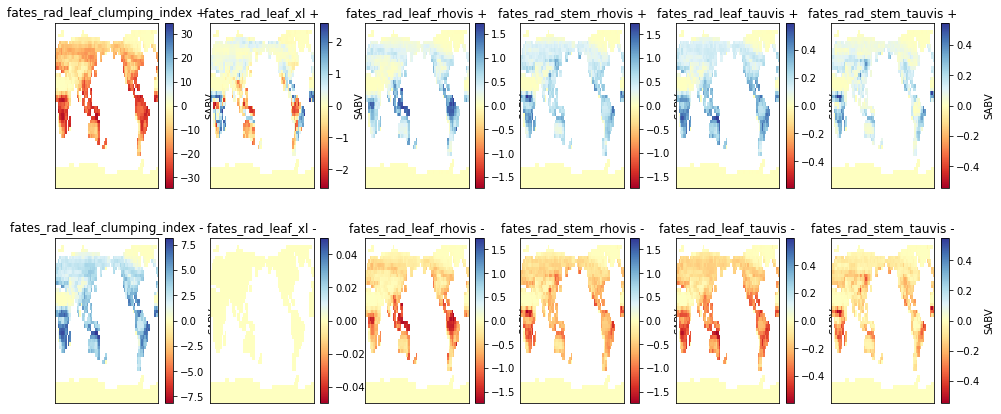

In [188]:
import time
rel=0
v=3
if doanalysis ==1:
    conv=1
    fig = plt.figure()
    plt.rcParams['figure.figsize'] = [19,7]
    fig.subplots_adjust(hspace=0.3, wspace=0.2)
    vs=range(1,ncases+1)
    ncol=7
    nrow=2
    count=1
    var_0=dsc.SABV.isel(ens=0)
    defm=np.multiply(np.mean(var_0,0),conv)
    for i in vs:
        index=((count+1) % 2)*ncol + ((count+1) // 2)
        print(index,count,(count+1) % 2,((count+1) // 2),(((count+1) // 2))-1)
        ax = fig.add_subplot(nrow, ncol, index)

        #ds0=dse1.isel(realization=i)
        var_i=dsc.SABV.isel(ens=i)
        mod=np.multiply(np.mean(var_i,0),conv)
        
        delt=mod-defm
        plt1=delt.plot(cmap='RdYlBu')
                    
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        if((count+1) % 2==0):
            ex=' +'
        else:
            ex=' -'
        ax.set_title(str(parameter_list[(((count+1) // 2))-1]+ex))
        count=count+1
        fig.canvas.draw()
        time.sleep(1) 
          

1 1 0 1 0
8 2 1 1 0
2 3 0 2 1
9 4 1 2 1
3 5 0 3 2
10 6 1 3 2
4 7 0 4 3
11 8 1 4 3
5 9 0 5 4
12 10 1 5 4
6 11 0 6 5
13 12 1 6 5


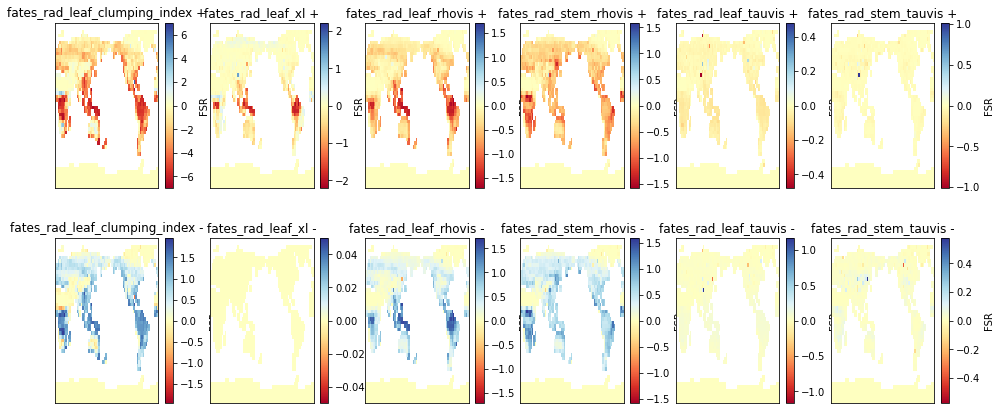

In [190]:
import time
rel=0
v=2
if doanalysis ==1:
    conv=1
    fig = plt.figure()
    plt.rcParams['figure.figsize'] = [19,7]
    fig.subplots_adjust(hspace=0.3, wspace=0.2)
    vs=range(1,ncases+1)
    ncol=7
    nrow=2
    count=1
    var_0=dsc.FSR.isel(ens=0)
    defm=np.multiply(np.mean(var_0,0),conv)
    for i in vs:
        index=((count+1) % 2)*ncol + ((count+1) // 2)
        print(index,count,(count+1) % 2,((count+1) // 2),(((count+1) // 2))-1)
        ax = fig.add_subplot(nrow, ncol, index)

        #ds0=dse1.isel(realization=i)
        var_i=dsc.FSR.isel(ens=i)
        mod=np.multiply(np.mean(var_i,0),conv)
        
        delt=mod-defm
        plt1=delt.plot(cmap='RdYlBu')
                    
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        if((count+1) % 2==0):
            ex=' +'
        else:
            ex=' -'
        ax.set_title(str(parameter_list[(((count+1) // 2))-1]+ex))
        count=count+1
        fig.canvas.draw()
        time.sleep(1) 
          